In [1]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import PIL.Image as Image
import os
import math

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
def lr_schedule(epoch):
    initial_lr = 0.001  # Initial learning rate
    drop = 0.5  # Learning rate drop factor
    epochs_drop = 20  # Number of epochs after which learning rate should drop
    lr = initial_lr * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lr

In [4]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [6]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    #horizontal_flip=True,
    #vertical_flip=True,
    rescale=1./255.0)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [7]:
main_path = os.getcwd() + '/covid_data'

train_dataset = train_datagen.flow_from_directory(
    directory= main_path + '/train/',
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=None)

val_dataset = val_datagen.flow_from_directory(
    directory = main_path + '/validation',
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=256,
    class_mode="categorical",
    shuffle=False,
    seed=None)

test_dataset = test_datagen.flow_from_directory(
    directory = main_path + '/test',
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=256,
    class_mode="categorical",
    shuffle=False,
    seed=None)

Found 14811 images belonging to 4 classes.
Found 2119 images belonging to 4 classes.
Found 4235 images belonging to 4 classes.


Class Names: {'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}


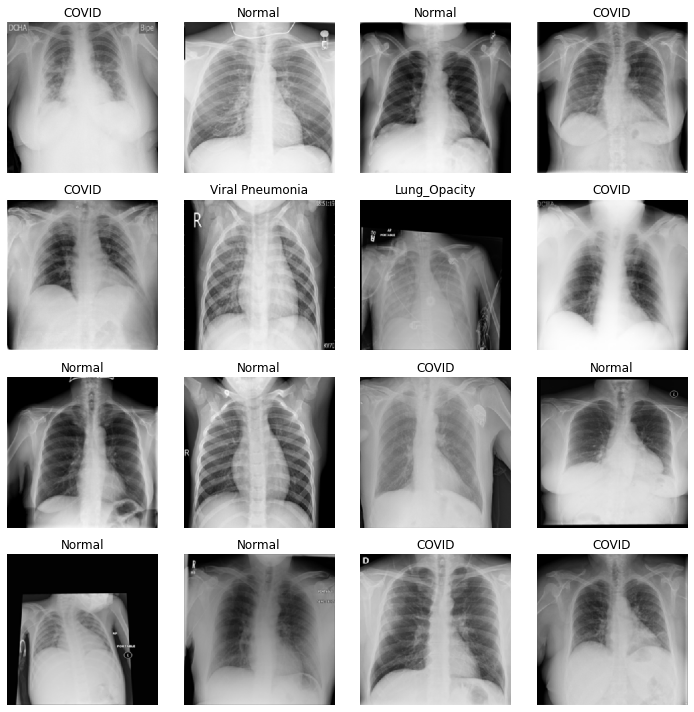

In [8]:
class_names = list(train_dataset.class_indices)
img, lab  = next(train_dataset)
lab = np.argmax(lab, axis = -1)
print('Class Names: {}'.format(train_dataset.class_indices))
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.imshow(img[i])
  plt.axis("off")
  plt.title(class_names[lab[i]])
  

plt.tight_layout()

In [9]:
for image_batch, labels_batch in train_dataset:
  print('Image Shape: {}'.format(image_batch.shape))
  print('Label Shape: {}'.format(labels_batch.shape))
  break

Image Shape: (32, 224, 224, 3)
Label Shape: (32, 4)


In [10]:
base_model = ResNet50(weights='imagenet', include_top=False)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(), loss=categorical_crossentropy, metrics=['categorical_accuracy'])

In [11]:
history = model.fit(train_dataset, validation_data=val_dataset,  epochs=75,callbacks=[LearningRateScheduler(lr_schedule),early_stopping])

Epoch 1/75
463/463 [==============================] - 109s 226ms/step - loss: 1.1637 - categorical_accuracy: 0.4894 - val_loss: 1.1359 - val_categorical_accuracy: 0.5663
Epoch 2/75
463/463 [==============================] - 105s 226ms/step - loss: 1.1051 - categorical_accuracy: 0.5282 - val_loss: 1.0763 - val_categorical_accuracy: 0.5838
Epoch 3/75
463/463 [==============================] - 100s 216ms/step - loss: 1.0721 - categorical_accuracy: 0.5515 - val_loss: 1.0644 - val_categorical_accuracy: 0.4889
Epoch 4/75
463/463 [==============================] - 104s 225ms/step - loss: 1.0454 - categorical_accuracy: 0.5684 - val_loss: 1.0125 - val_categorical_accuracy: 0.5852
Epoch 5/75
463/463 [==============================] - 108s 233ms/step - loss: 1.0274 - categorical_accuracy: 0.5744 - val_loss: 1.0107 - val_categorical_accuracy: 0.5762
Epoch 6/75
463/463 [==============================] - 101s 219ms/step - loss: 1.0095 - categorical_accuracy: 0.5806 - val_loss: 0.9927 - val_categoric

463/463 [==============================] - 97s 210ms/step - loss: 0.8199 - categorical_accuracy: 0.6679 - val_loss: 0.8101 - val_categorical_accuracy: 0.6739
Epoch 50/75
463/463 [==============================] - 86s 186ms/step - loss: 0.8191 - categorical_accuracy: 0.6679 - val_loss: 0.8098 - val_categorical_accuracy: 0.6593
Epoch 51/75
463/463 [==============================] - 97s 210ms/step - loss: 0.8188 - categorical_accuracy: 0.6675 - val_loss: 0.8092 - val_categorical_accuracy: 0.6711
Epoch 52/75
463/463 [==============================] - 89s 192ms/step - loss: 0.8167 - categorical_accuracy: 0.6703 - val_loss: 0.8125 - val_categorical_accuracy: 0.6513
Epoch 53/75
463/463 [==============================] - 87s 189ms/step - loss: 0.8163 - categorical_accuracy: 0.6673 - val_loss: 0.8076 - val_categorical_accuracy: 0.6588
Epoch 54/75
463/463 [==============================] - 89s 191ms/step - loss: 0.8164 - categorical_accuracy: 0.6689 - val_loss: 0.8061 - val_categorical_accuracy:

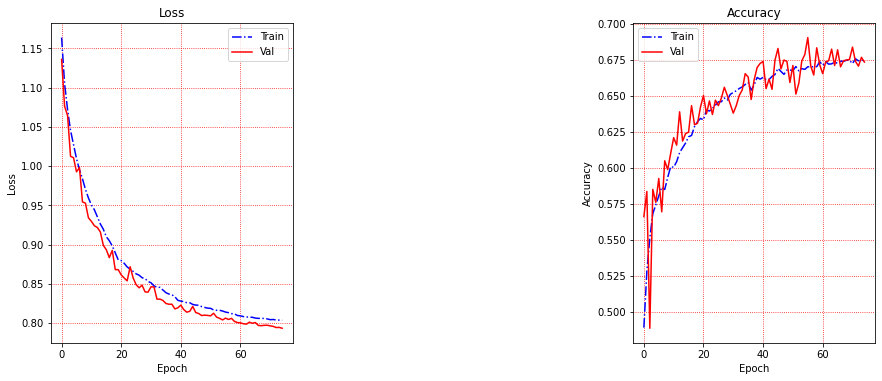

In [12]:
plt.figure(figsize = (20, 20))
plt.subplot(341)
plt.plot(history.history['loss'], color='blue', linestyle = 'dashdot', label='Train')
plt.plot(history.history['val_loss'], color='red', linestyle="solid", label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.grid(visible = True, which = 'both', color= 'r', linestyle = 'dotted')
plt.legend()

plt.subplot(343)
plt.plot(history.history['categorical_accuracy'], color='blue', linestyle = 'dashdot', label='Train')
plt.plot(history.history['val_categorical_accuracy'], color='red', linestyle="solid", label='Val')
# plt.xticks(np.arange(0, 31, step=2))  # Set label locations.
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.grid(visible = True, which = 'both', color= 'r', linestyle = 'dotted')
plt.legend()

17/17 [==============================] - 23s 1s/step - loss: 0.7974 - categorical_accuracy: 0.6715
Test Loss: 0.7974216341972351
Test Accuracy: 0.6715466380119324


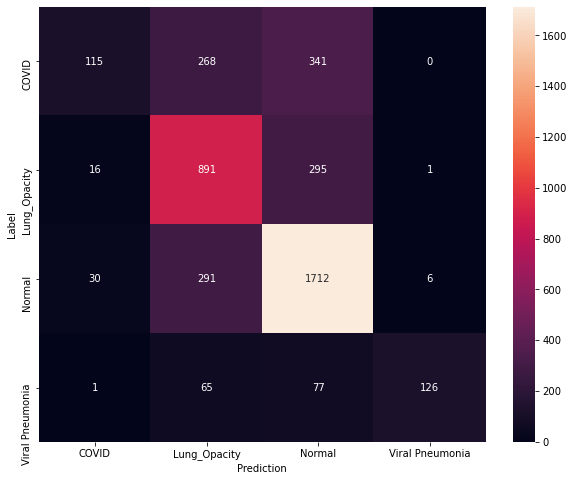

In [13]:
test_result = model.evaluate(test_dataset, batch_size = 128)

print('Test Loss: {}'.format(test_result[0]))
print('Test Accuracy: {}'.format(test_result[1]))

class_names = list(train_dataset.class_indices)

label_names = class_names
y_pred = model.predict(test_dataset, batch_size=128)
y_test = test_dataset.labels
cm = tf.math.confusion_matrix(y_test, 
                              y_pred.argmax(axis=1),
                              num_classes = 4)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, xticklabels=class_names, yticklabels=class_names, 
              annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.savefig('CM.png', dpi = 300)
plt.show()